In [11]:
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

Taking an example word vector, we break it down into three component vectors : q, k and v. So if the word vector is 512 X 1 vector, so is q, k and v. 

Each of these component vectors is broken down into certain number of pieces say, p pieces. Each piece will be a part of creating an attention head. Each of these will be fed into an attention unit. 

For each head we are going to generate an attention matrix. The dimension of this matrix is going to be
 seq length X seq length

The number of attention matrices = number of attention heads 

The output vectors are concatenated in order to create a vector which has a very good contextual awareness. 

Let's take 4 words : word1 word2 word3 word4

In [2]:
seq_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size,seq_length,input_dim))

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
split_layer = nn.Linear(input_dim,3*d_model)

The input is mapped from a dimension of 'input_dim' to 3 times the model's dimension 'd_model'. This is done to create the q-k-v vectors and eventually concatenated. 

In [5]:
qkv = split_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

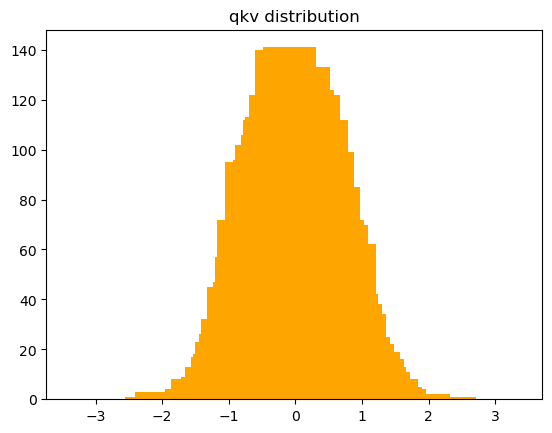

In [7]:
y_val = torch.histc(qkv,bins=200,min=-3,max=3)
x_val = np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center',color=['orange'])
plt.title('qkv distribution')

In [8]:
num_heads = 8 
head_dim = d_model//num_heads
qkv = qkv.reshape(batch_size,seq_length,num_heads,3*head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [9]:
qkv = qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [10]:
q,k,v = qkv.chunk(3,dim=-1)
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [12]:
dk = q.size()[-1]
scaled = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(dk)
scaled.shape

torch.Size([1, 8, 4, 4])

Every word has a query vector and it's going to compare it's query vector to every other word's key vector. That is represented by the matrix multiplication. 


In [13]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [14]:
y = torch.randn(2,3)
torch.transpose(y,0,1)
torch.transpose(y,1,0)

tensor([[ 1.1755, -0.1487],
        [-0.1463,  1.3898],
        [-0.0720,  1.3809]])

In [16]:
mask = torch.full(scaled.size(),float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [17]:
(scaled + mask)[0][0]

tensor([[-0.1795,    -inf,    -inf,    -inf],
        [-0.3720,  0.4157,    -inf,    -inf],
        [-0.0636, -0.0818, -0.0035,    -inf],
        [ 0.4979, -0.5848, -0.3639, -0.3039]], grad_fn=<SelectBackward0>)

In [18]:
scaled += mask

In [19]:
attention = F.softmax(scaled,dim=-1)

In [20]:
attention.shape

torch.Size([1, 8, 4, 4])

In [21]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3127, 0.6873, 0.0000, 0.0000],
        [0.3285, 0.3226, 0.3489, 0.0000],
        [0.4526, 0.1533, 0.1912, 0.2030]], grad_fn=<SelectBackward0>)

In [22]:
values = torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

In [23]:
def scaled_dot_product(q,k,v,mask = None):
    dk = q.size()[-1]
    scaled = torch.matmul(q,k.transpose(-1,-2)) / math.sqrt(dk)
    if mask is not None:
        scaled += mask 
    attention = F.softmax(scaled,dim=-1)
    values = torch.matmul(attention,v)
    return values,attention 






In [24]:
values,attention = scaled_dot_product(q,k,v,mask=mask)
attention.shape

torch.Size([1, 8, 4, 4])

In [25]:
attention[0][0]
values.size()

torch.Size([1, 8, 4, 64])

In [26]:
values = values.reshape(batch_size,seq_length,num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [27]:
linear_layer = nn.Linear(d_model,d_model)
out = linear_layer(values)

In [28]:
out.shape

torch.Size([1, 4, 512])